# EDA : Analyse Exploratoire des données


## Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import cv2

from PIL import Image, ImageOps, ImageDraw, ImageFont
from src.detection.category_utils import CATIDX_2_EN_CATNAME,CATIDX_2_FR_CATNAME, EN_CATNAME_2_CATIDX, EN_CATNAME_2_EMOJI, EN_SUPERCATNAME_2_FR_SUPERCATNAME, EN_CATNAME_2_FR_CATNAME, CATIDX_2_EN_SUPERCATNAME



In [2]:
# {supercatname} - {catname_fr}
", ".join( [f"{cat_id:02d}#{CATIDX_2_EN_SUPERCATNAME[cat_id]}#{EN_CATNAME_2_FR_CATNAME[cat_name]}" for cat_id, cat_name in CATIDX_2_EN_CATNAME.items()])

"00#Aluminium foil#Papier d'aluminium, 01#Battery#Batterie, 02#Blister pack#Plaquette thermoformée en aluminium, 03#Blister pack#Plaquette thermoformée à carte, 04#Bottle#Autre bouteille en plastique, 05#Bottle#Bouteille en plastique transparente, 06#Bottle#Bouteille en verre, 07#Bottle cap#Bouchon de bouteille en plastique, 08#Bottle cap#Bouchon de bouteille en métal, 09#Broken glass#Verre brisé, 10#Can#Boîte de conserve, 11#Can#Aérosol, 12#Can#Canette de boisson, 13#Carton#Tube de papier toilette, 14#Carton#Autre carton, 15#Carton#Boîte à œufs, 16#Carton#Brique de boisson, 17#Carton#Carton ondulé, 18#Carton#Boîte alimentaire en carton, 19#Carton#Boîte à pizza, 20#Cup#Gobelet en papier, 21#Cup#Gobelet en plastique jetable, 22#Cup#Gobelet en mousse, 23#Cup#Tasse en verre, 24#Cup#Autre gobelet en plastique, 25#Food waste#Déchets alimentaires, 26#Glass jar#Pot en verre, 27#Lid#Couvercle en plastique, 28#Lid#Couvercle en métal, 29#Other plastic#Autre plastique, 30#Paper#Papier de magazine

## Meta Dataset Loading
Chargement du dataset

In [3]:
TACO_DATASET_ROOT_PATH = r"N:\My Drive\KESKIA Drive Mlamali\datasets\raw\taco-2gb"

taco_meta_df = pd.read_csv(f'{TACO_DATASET_ROOT_PATH}/meta_df.csv')
taco_meta_df["path"] = taco_meta_df["img_file"].apply(lambda x: os.path.join(TACO_DATASET_ROOT_PATH, "data", x))
print(f"shape : {taco_meta_df.shape}")
taco_meta_df

shape : (4784, 14)


,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area,path
0,0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0000,127.0000,447.0000,1322.0,4.039540e+05,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
1,1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0000,457.0000,1429.0000,1519.0,1.071260e+06,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
2,1,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0000,292.0000,1006.0000,672.0,9.958350e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
3,2,1537,2049,batch_1/000010.jpg,5,Clear plastic bottle,Bottle,4,632.0000,987.0000,500.0000,374.0,7.383250e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
4,2,1537,2049,batch_1/000010.jpg,7,Plastic bottle cap,Bottle cap,5,632.0000,989.0000,44.0000,51.0,9.150000e+02,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,1498,1824,4000,batch_9/000098.jpg,16,Drink carton,Carton,4779,228.7143,1550.0476,1007.9999,579.0,5.032469e+05,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
4780,1498,1824,4000,batch_9/000098.jpg,7,Plastic bottle cap,Bottle cap,4780,1041.3334,1721.7142,141.0000,138.0,1.449450e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
4781,1499,1824,4000,batch_9/000099.jpg,39,Other plastic wrapper,Plastic bag & wrapper,4781,862.0274,1331.2500,505.9726,612.5,1.549541e+05,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...
4782,1499,1824,4000,batch_9/000099.jpg,14,Other carton,Carton,4782,966.0000,1996.0000,211.0000,336.0,2.867500e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...


### Fuse annotations data with meta_df

In [4]:
annotation_path = f'{TACO_DATASET_ROOT_PATH}/data/annotations.json'
with open(annotation_path, 'r') as f:
    annotations = json.load(f)

print(f"keys : {annotations.keys()}")
annotations_dfs_dict = {k : pd.json_normalize(v) for k, v in annotations.items()}

keys : dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


In [5]:
annotations_dfs_dict["scene_categories"]

,id,name
0,0,Clean
1,1,"Indoor, Man-made"
2,2,Pavement
3,3,"Sand, Dirt, Pebbles"
4,4,Trash
5,5,Vegetation
6,6,Water


In [6]:
# rename columns image_id -> img_id
annotations_dfs_dict["scene_annotations"].rename(columns={"image_id": "img_id"}, inplace=True)
annotations_dfs_dict["scene_annotations"]

,img_id,background_ids
0,0,[1]
1,1,[1]
2,2,[2]
3,3,[5]
4,4,[5]
...,...,...
4291,1495,"[5, 3]"
4292,1496,"[5, 3]"
4293,1497,[2]
4294,1498,[2]


In [7]:
# join on "img_id"
pd.merge(taco_meta_df, annotations_dfs_dict["scene_annotations"], on="img_id", how="left")

,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area,path,background_ids
0,0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0000,127.00,447.0000,1322.0,4.039540e+05,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[1]
1,1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0000,457.00,1429.0000,1519.0,1.071260e+06,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[1]
2,1,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0000,292.00,1006.0000,672.0,9.958350e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[1]
3,2,1537,2049,batch_1/000010.jpg,5,Clear plastic bottle,Bottle,4,632.0000,987.00,500.0000,374.0,7.383250e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[2]
4,2,1537,2049,batch_1/000010.jpg,7,Plastic bottle cap,Bottle cap,5,632.0000,989.00,44.0000,51.0,9.150000e+02,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13490,1499,1824,4000,batch_9/000099.jpg,39,Other plastic wrapper,Plastic bag & wrapper,4781,862.0274,1331.25,505.9726,612.5,1.549541e+05,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[5]
13491,1499,1824,4000,batch_9/000099.jpg,14,Other carton,Carton,4782,966.0000,1996.00,211.0000,336.0,2.867500e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[2]
13492,1499,1824,4000,batch_9/000099.jpg,14,Other carton,Carton,4782,966.0000,1996.00,211.0000,336.0,2.867500e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[5]
13493,1499,1824,4000,batch_9/000099.jpg,6,Glass bottle,Bottle,4783,1125.0000,1858.00,234.0000,510.0,6.858950e+04,N:\My Drive\KESKIA Drive Mlamali\datasets\raw\...,[2]


## Overview

#todo :
Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500

In [8]:
taco_meta_df.columns

Index(['img_id', 'img_width', 'img_height', 'img_file', 'cat_id', 'cat_name',
       'supercategory', 'ann_id', 'x', 'y', 'width', 'height', 'area', 'path'],
      dtype='object')

In [9]:
taco_meta_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4784 entries, 0 to 4783
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   img_id         4784 non-null   int64  
 1   img_width      4784 non-null   int64  
 2   img_height     4784 non-null   int64  
 3   img_file       4784 non-null   object 
 4   cat_id         4784 non-null   int64  
 5   cat_name       4784 non-null   object 
 6   supercategory  4784 non-null   object 
 7   ann_id         4784 non-null   int64  
 8   x              4784 non-null   float64
 9   y              4784 non-null   float64
 10  width          4784 non-null   float64
 11  height         4784 non-null   float64
 12  area           4784 non-null   float64
 13  path           4784 non-null   object 
dtypes: float64(5), int64(5), object(4)
memory usage: 523.4+ KB


## Stats

In [10]:
taco_meta_df.describe().T

,count,mean,std,min,25%,50%,75%,max
img_id,4784.0,756.936037,445.884396,0.000000,354.75,743.00,1154.000,1499.0
img_width,4784.0,2794.278428,714.851079,842.000000,2448.00,2448.00,3264.000,6000.0
img_height,4784.0,3234.358278,837.244672,474.000000,2448.00,3264.00,4000.000,5312.0
cat_id,4784.0,34.079013,20.081707,0.000000,12.00,36.00,57.000,59.0
ann_id,4784.0,2391.949833,1381.264283,1.000000,1195.75,2392.50,3588.250,4783.0
x,4784.0,1232.285117,703.739763,-1.000000,741.60,1150.00,1612.000,5573.0
y,4784.0,1485.067894,826.005410,-1.316667,892.75,1414.00,1961.250,5208.0
width,4784.0,331.434419,440.431739,10.000000,68.00,179.50,405.250,3758.0
height,4784.0,320.246833,442.046602,4.000000,62.00,159.00,387.000,3995.0
area,4784.0,150407.154132,485084.750277,55.500000,2142.00,14244.75,75333.125,7328035.5


## Cleaning

### Missing Values
Vérification si présence des valeurs manquantes

<Axes: title={'center': 'Missing Values'}>

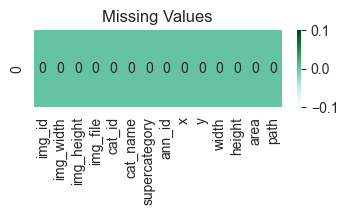

In [11]:
#Valeurs nulles
fig, ax = plt.subplots(figsize=(4, 1))
plt.title('Missing Values')
nans = taco_meta_df.isna().sum().sort_values(ascending=False).to_frame().T
sns.heatmap(nans, annot=True, fmt='d', cmap='BuGn')

Remarque : Il n'y a pas de valeurs manquantes

### Duplicates

In [12]:
taco_meta_df.duplicated().sum()

0

In [13]:
subset = ['cat_name', 'supercategory', 'x', 'y', 'width', 'height', 'area']
taco_meta_df.duplicated(subset=subset).sum()

0

Remarque : Il n'y a pas de valeurs dupliquées.

## Images

In [14]:
# img_id unique count
print(f"{taco_meta_df['img_file'].nunique()} uniques images")

1500 uniques images


In [15]:
print(f"{taco_meta_df['img_id'].nunique()} uniques img_id")

1500 uniques img_id


## Class Analysis

### Class "cat_name" Distribution

In [16]:
n_cat_name = taco_meta_df['cat_name'].nunique()
print(f"{n_cat_name} unique cat_name")
taco_meta_df['cat_name'].unique().tolist()

59 unique cat_name


['Glass bottle',
 'Meal carton',
 'Other carton',
 'Clear plastic bottle',
 'Plastic bottle cap',
 'Drink can',
 'Food Can',
 'Other plastic bottle',
 'Pop tab',
 'Aerosol',
 'Glass cup',
 'Other plastic wrapper',
 'Styrofoam piece',
 'Plastic film',
 'Other plastic',
 'Drink carton',
 'Metal bottle cap',
 'Disposable food container',
 'Normal paper',
 'Paper cup',
 'Cigarette',
 'Single-use carrier bag',
 'Tissues',
 'Toilet tube',
 'Crisp packet',
 'Plastic lid',
 'Metal lid',
 'Egg carton',
 'Plastic straw',
 'Paper bag',
 'Disposable plastic cup',
 'Broken glass',
 'Plastic utensils',
 'Glass jar',
 'Food waste',
 'Squeezable tube',
 'Spread tub',
 'Shoe',
 'Garbage bag',
 'Aluminium foil',
 'Six pack rings',
 'Foam cup',
 'Paper straw',
 'Corrugated carton',
 'Unlabeled litter',
 'Aluminium blister pack',
 'Battery',
 'Rope & strings',
 'Other plastic container',
 'Polypropylene bag',
 'Scrap metal',
 'Magazine paper',
 'Pizza box',
 'Plastic glooves',
 'Wrapping paper',
 'Carded 

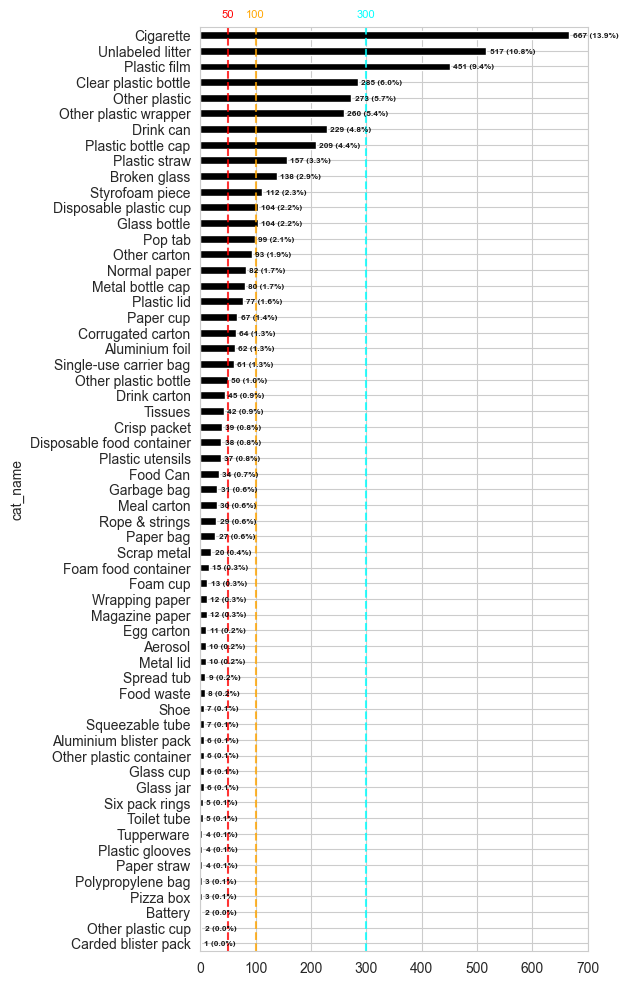

In [17]:
fig, ax = plt.subplots(figsize=(5, 12))
cat_name_counts = taco_meta_df['cat_name'].value_counts(ascending=True)

#print(cat_name_counts / cat_name_counts.sum() * 100)
cat_name_counts.plot(kind='barh', ax=ax, color='black')
# add % to the plot
for i, v in enumerate(cat_name_counts):
    ax.text(v + 6, i - 0.15, f"{v} ({v / cat_name_counts.sum():.1%})", color='black', fontweight='bold', fontsize=6,
            alpha=0.9)

for xc, color in zip([50, 100, 300], ['r', 'orange', 'cyan']):
    ax.text(xc, n_cat_name, str(xc), fontsize=8, color=color, va="bottom", ha="center")
    plt.axvline(x=xc, color=color, linestyle='--', alpha=0.8)

plt.show()

In [18]:
for cat, count in cat_name_counts.items():
    cat_id = EN_CATNAME_2_CATIDX[cat]
    supercat = CATIDX_2_EN_SUPERCATNAME[cat_id]
    print(f"{supercat} > {cat} ({EN_CATNAME_2_FR_CATNAME[cat]}) {EN_CATNAME_2_EMOJI[cat]} : {count}")

Blister pack > Carded blister pack (Plaquette thermoformée à carte) 💊🃏 : 1
Cup > Other plastic cup (Autre gobelet en plastique) 🥤 : 2
Battery > Battery (Batterie) 🔋 : 2
Carton > Pizza box (Boîte à pizza) 🍕📦 : 3
Plastic bag & wrapper > Polypropylene bag (Sac en polypropylène) ♻️ : 3
Straw > Paper straw (Paille en papier) 🥤 : 4
Plastic glooves > Plastic glooves (Gants en plastique) 🧤 : 4
Plastic container > Tupperware (Tupperware) 🥡 : 4
Carton > Toilet tube (Tube de papier toilette) 🧻 : 5
Plastic bag & wrapper > Six pack rings (Anneaux de canette) 🍺 : 5
Glass jar > Glass jar (Pot en verre) 🍯 : 6
Cup > Glass cup (Tasse en verre) 🥃 : 6
Plastic container > Other plastic container (Autre contenant en plastique) ♻️ : 6
Blister pack > Aluminium blister pack (Plaquette thermoformée en aluminium) 💊 : 6
Squeezable tube > Squeezable tube (Tube compressible) 🧴 : 7
Shoe > Shoe (Chaussure) 👟 : 7
Food waste > Food waste (Déchets alimentaires) 🍽️🗑️ : 8
Plastic container > Spread tub (Pot de tartinade) 

In [19]:
# display cat_name with count < 5
threadshold = 5
print(f"cat_names with count < {threadshold} : {cat_name_counts[cat_name_counts < threadshold].index.tolist()}")

cat_names with count < 5 : ['Carded blister pack', 'Other plastic cup', 'Battery', 'Pizza box', 'Polypropylene bag', 'Paper straw', 'Plastic glooves', 'Tupperware']


### Class "supercategory" Distribution

In [20]:
n_supercategory = taco_meta_df['supercategory'].nunique()
print(f"{n_supercategory} unique supercategory")
taco_meta_df['supercategory'].unique().tolist()

28 unique supercategory


['Bottle',
 'Carton',
 'Bottle cap',
 'Can',
 'Pop tab',
 'Cup',
 'Plastic bag & wrapper',
 'Styrofoam piece',
 'Other plastic',
 'Plastic container',
 'Paper',
 'Cigarette',
 'Lid',
 'Straw',
 'Paper bag',
 'Broken glass',
 'Plastic utensils',
 'Glass jar',
 'Food waste',
 'Squeezable tube',
 'Shoe',
 'Aluminium foil',
 'Unlabeled litter',
 'Blister pack',
 'Battery',
 'Rope & strings',
 'Scrap metal',
 'Plastic glooves']

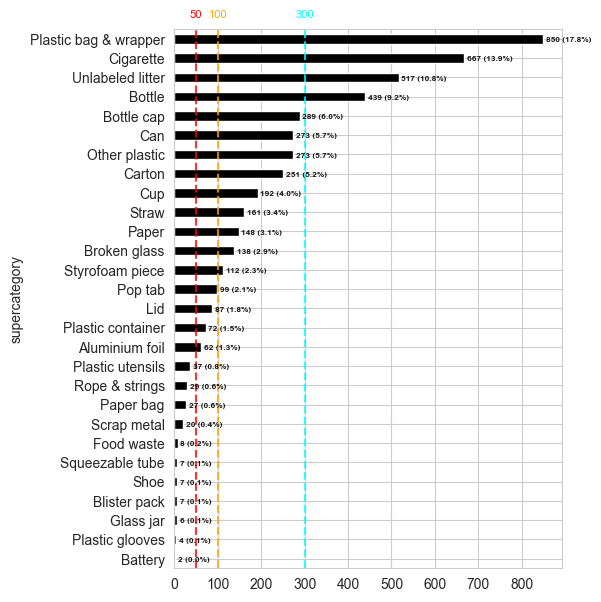

In [21]:
fig, ax = plt.subplots(figsize=(5, 7))
supercategory_counts = taco_meta_df['supercategory'].value_counts(ascending=True)

supercategory_counts.plot(kind='barh', ax=ax, color='black')
# add % to the plot
for i, v in enumerate(supercategory_counts):
    ax.text(v + 6, i - 0.15, f"{v} ({v / supercategory_counts.sum():.1%})", color='black', fontweight='bold', fontsize=6,
            alpha=0.9)

for xc, color in zip([50, 100, 300], ['r', 'orange', 'cyan']):
    ax.text(xc, n_supercategory, str(xc), fontsize=8, color=color, va="bottom", ha="center")
    plt.axvline(x=xc, color=color, linestyle='--', alpha=0.8)

plt.show()

In [22]:
# display supercategory with count < 5
threadshold = 10
print(f"supercategory with count < {threadshold} : {supercategory_counts[supercategory_counts < threadshold].index.tolist()}")


supercategory with count < 10 : ['Battery', 'Plastic glooves', 'Glass jar', 'Blister pack', 'Shoe', 'Squeezable tube', 'Food waste']


### Presence of "cat_name == 'Plastified paper bag'

On remarque qu'il n'y a aucun objet de type "Plastified paper bag" dans le dataset.
Pourtant, cette catégorie est présente, avec un id unique : 35

In [23]:
# query example with cat_id == 35
taco_meta_df.query("cat_id == 35")

,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area,path


In [24]:
taco_meta_df.query("cat_name == 'Plastified paper bag'")

,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area,path


### Export mapping cat_name & supercategory

In [25]:
print(annotations_dfs_dict.keys())
annotations_dfs_dict["categories"]

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


,supercategory,id,name
0,Aluminium foil,0,Aluminium foil
1,Battery,1,Battery
2,Blister pack,2,Aluminium blister pack
3,Blister pack,3,Carded blister pack
4,Bottle,4,Other plastic bottle
5,Bottle,5,Clear plastic bottle
6,Bottle,6,Glass bottle
7,Bottle cap,7,Plastic bottle cap
8,Bottle cap,8,Metal bottle cap
9,Broken glass,9,Broken glass


 cat_id -> cat_name

In [26]:
cat_idx_2_cat_name = {row['id']: row['name'] for idx, row in annotations_dfs_dict["categories"].iterrows()}
cat_idx_2_cat_name

{0: 'Aluminium foil',
 1: 'Battery',
 2: 'Aluminium blister pack',
 3: 'Carded blister pack',
 4: 'Other plastic bottle',
 5: 'Clear plastic bottle',
 6: 'Glass bottle',
 7: 'Plastic bottle cap',
 8: 'Metal bottle cap',
 9: 'Broken glass',
 10: 'Food Can',
 11: 'Aerosol',
 12: 'Drink can',
 13: 'Toilet tube',
 14: 'Other carton',
 15: 'Egg carton',
 16: 'Drink carton',
 17: 'Corrugated carton',
 18: 'Meal carton',
 19: 'Pizza box',
 20: 'Paper cup',
 21: 'Disposable plastic cup',
 22: 'Foam cup',
 23: 'Glass cup',
 24: 'Other plastic cup',
 25: 'Food waste',
 26: 'Glass jar',
 27: 'Plastic lid',
 28: 'Metal lid',
 29: 'Other plastic',
 30: 'Magazine paper',
 31: 'Tissues',
 32: 'Wrapping paper',
 33: 'Normal paper',
 34: 'Paper bag',
 35: 'Plastified paper bag',
 36: 'Plastic film',
 37: 'Six pack rings',
 38: 'Garbage bag',
 39: 'Other plastic wrapper',
 40: 'Single-use carrier bag',
 41: 'Polypropylene bag',
 42: 'Crisp packet',
 43: 'Spread tub',
 44: 'Tupperware',
 45: 'Disposable 

cat_id -> supercategory

In [27]:
cat_idx_2_supercat_name = {row['id']: row['supercategory'] for idx, row in annotations_dfs_dict["categories"].iterrows()}
cat_idx_2_supercat_name

{0: 'Aluminium foil',
 1: 'Battery',
 2: 'Blister pack',
 3: 'Blister pack',
 4: 'Bottle',
 5: 'Bottle',
 6: 'Bottle',
 7: 'Bottle cap',
 8: 'Bottle cap',
 9: 'Broken glass',
 10: 'Can',
 11: 'Can',
 12: 'Can',
 13: 'Carton',
 14: 'Carton',
 15: 'Carton',
 16: 'Carton',
 17: 'Carton',
 18: 'Carton',
 19: 'Carton',
 20: 'Cup',
 21: 'Cup',
 22: 'Cup',
 23: 'Cup',
 24: 'Cup',
 25: 'Food waste',
 26: 'Glass jar',
 27: 'Lid',
 28: 'Lid',
 29: 'Other plastic',
 30: 'Paper',
 31: 'Paper',
 32: 'Paper',
 33: 'Paper',
 34: 'Paper bag',
 35: 'Paper bag',
 36: 'Plastic bag & wrapper',
 37: 'Plastic bag & wrapper',
 38: 'Plastic bag & wrapper',
 39: 'Plastic bag & wrapper',
 40: 'Plastic bag & wrapper',
 41: 'Plastic bag & wrapper',
 42: 'Plastic bag & wrapper',
 43: 'Plastic container',
 44: 'Plastic container',
 45: 'Plastic container',
 46: 'Plastic container',
 47: 'Plastic container',
 48: 'Plastic glooves',
 49: 'Plastic utensils',
 50: 'Pop tab',
 51: 'Rope & strings',
 52: 'Scrap metal',
 

supercat_idx -> supercategory_name

In [28]:
supercat_idx_2_supercat_name = {i : supercat_name for i, supercat_name in enumerate(annotations_dfs_dict["categories"]['supercategory'].unique().tolist())}
supercat_idx_2_supercat_name 

{0: 'Aluminium foil',
 1: 'Battery',
 2: 'Blister pack',
 3: 'Bottle',
 4: 'Bottle cap',
 5: 'Broken glass',
 6: 'Can',
 7: 'Carton',
 8: 'Cup',
 9: 'Food waste',
 10: 'Glass jar',
 11: 'Lid',
 12: 'Other plastic',
 13: 'Paper',
 14: 'Paper bag',
 15: 'Plastic bag & wrapper',
 16: 'Plastic container',
 17: 'Plastic glooves',
 18: 'Plastic utensils',
 19: 'Pop tab',
 20: 'Rope & strings',
 21: 'Scrap metal',
 22: 'Shoe',
 23: 'Squeezable tube',
 24: 'Straw',
 25: 'Styrofoam piece',
 26: 'Unlabeled litter',
 27: 'Cigarette'}

display list str "supercategory_name > cat_name (cat_name_fr) : count"

In [29]:
EN_SUPERCATNAME_2_FR_SUPERCATNAME

{'Aluminium foil': "Papier d'aluminium",
 'Battery': 'Batterie',
 'Blister pack': 'Plaquette thermoformée',
 'Bottle': 'Bouteille',
 'Bottle cap': 'Bouchon de bouteille',
 'Broken glass': 'Verre brisé',
 'Can': 'Canette',
 'Carton': 'Carton',
 'Cup': 'Tasse',
 'Food waste': 'Déchets alimentaires',
 'Glass jar': 'Pot en verre',
 'Lid': 'Couvercle',
 'Other plastic': 'Autre plastique',
 'Paper': 'Papier',
 'Paper bag': 'Sac en papier',
 'Plastic bag & wrapper': 'Sac en plastique et emballage',
 'Plastic container': 'Conteneur en plastique',
 'Plastic glooves': 'Gants en plastique',
 'Plastic utensils': 'Ustensiles en plastique',
 'Pop tab': 'Onglet de canette',
 'Rope & strings': 'Corde et ficelles',
 'Scrap metal': 'Métal usagé',
 'Shoe': 'Chaussure',
 'Squeezable tube': 'Tube compressible',
 'Straw': 'Paille',
 'Styrofoam piece': 'Morceau de polystyrène',
 'Unlabeled litter': 'Déchets non étiquetés',
 'Cigarette': 'Cigarette'}

In [30]:
for cat_name in cat_name_counts.index.tolist():
    cat_id = EN_CATNAME_2_CATIDX[cat_name]
    supercat_name = CATIDX_2_EN_SUPERCATNAME[cat_id]
    print(f"{supercat_name} > {cat_name} ({EN_CATNAME_2_FR_CATNAME[cat_name]}) {EN_CATNAME_2_EMOJI[cat_name]} : {cat_name_counts[cat_name]}")

Blister pack > Carded blister pack (Plaquette thermoformée à carte) 💊🃏 : 1
Cup > Other plastic cup (Autre gobelet en plastique) 🥤 : 2
Battery > Battery (Batterie) 🔋 : 2
Carton > Pizza box (Boîte à pizza) 🍕📦 : 3
Plastic bag & wrapper > Polypropylene bag (Sac en polypropylène) ♻️ : 3
Straw > Paper straw (Paille en papier) 🥤 : 4
Plastic glooves > Plastic glooves (Gants en plastique) 🧤 : 4
Plastic container > Tupperware (Tupperware) 🥡 : 4
Carton > Toilet tube (Tube de papier toilette) 🧻 : 5
Plastic bag & wrapper > Six pack rings (Anneaux de canette) 🍺 : 5
Glass jar > Glass jar (Pot en verre) 🍯 : 6
Cup > Glass cup (Tasse en verre) 🥃 : 6
Plastic container > Other plastic container (Autre contenant en plastique) ♻️ : 6
Blister pack > Aluminium blister pack (Plaquette thermoformée en aluminium) 💊 : 6
Squeezable tube > Squeezable tube (Tube compressible) 🧴 : 7
Shoe > Shoe (Chaussure) 👟 : 7
Food waste > Food waste (Déchets alimentaires) 🍽️🗑️ : 8
Plastic container > Spread tub (Pot de tartinade) 

### Linked Graph

In [31]:
print(annotations_dfs_dict.keys())
annotations_dfs_dict["categories"]["fr_name"] = annotations_dfs_dict["categories"]["name"].apply(lambda x: EN_CATNAME_2_FR_CATNAME[x])
annotations_dfs_dict["categories"]["fr_supername"] = annotations_dfs_dict["categories"]["supercategory"].apply(lambda x: EN_SUPERCATNAME_2_FR_SUPERCATNAME[x])
annotations_dfs_dict["categories"]

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


,supercategory,id,name,fr_name,fr_supername
0,Aluminium foil,0,Aluminium foil,Papier d'aluminium,Papier d'aluminium
1,Battery,1,Battery,Batterie,Batterie
2,Blister pack,2,Aluminium blister pack,Plaquette thermoformée en aluminium,Plaquette thermoformée
3,Blister pack,3,Carded blister pack,Plaquette thermoformée à carte,Plaquette thermoformée
4,Bottle,4,Other plastic bottle,Autre bouteille en plastique,Bouteille
5,Bottle,5,Clear plastic bottle,Bouteille en plastique transparente,Bouteille
6,Bottle,6,Glass bottle,Bouteille en verre,Bouteille
7,Bottle cap,7,Plastic bottle cap,Bouchon de bouteille en plastique,Bouchon de bouteille
8,Bottle cap,8,Metal bottle cap,Bouchon de bouteille en métal,Bouchon de bouteille
9,Broken glass,9,Broken glass,Verre brisé,Verre brisé


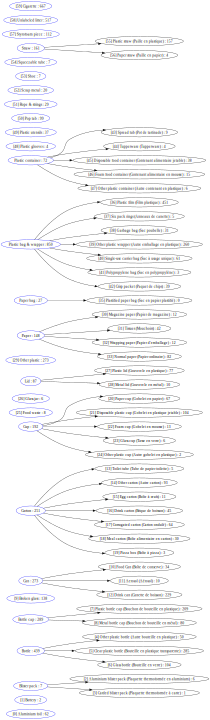

In [33]:
from graphviz import Digraph

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
# Note: graphviz may require more than pip installation due to path issue: e.g. brew install graphviz for mac

#g = Digraph('G', filename='hello.gv')
dot = Digraph('Dataset graph', filename='reports/eda/base_dataset_graph.gv')
dot.attr(rankdir='LR', size='8,10')

for i,cat_it in annotations_dfs_dict["categories"].iterrows():
    cat_name = cat_it['name']
    supercat_name = cat_it['supercategory']
    cat_id = cat_it['id']
    
    if cat_name in cat_name_counts:
        cat_count = cat_name_counts[cat_name]
    else:
        cat_count = 0
        
    if supercat_name in supercategory_counts:
        supercat_count = supercategory_counts[supercat_name]
    else:
        supercat_count = 0
        

    dot.node(f'{cat_name}', label=f'[{cat_id}] {cat_name} ({cat_it["fr_name"]}) : {cat_count}')
    if cat_name==supercat_name:
        dot.node(supercat_name, label=f'[{cat_id}] {supercat_name} : {supercat_count}', color='blue')
    else:
        dot.node(supercat_name, label=f'{supercat_name} : {supercat_count}', color='blue')
        dot.edge(supercat_name, cat_name)


dot.save()
dot.view(quiet_view=True)
dot

## Scene Distribution

#todo, impact de la scene sur yolo 
scene c'est important ? rappel de comment fonctionne yolo

## Width & Height Distribution

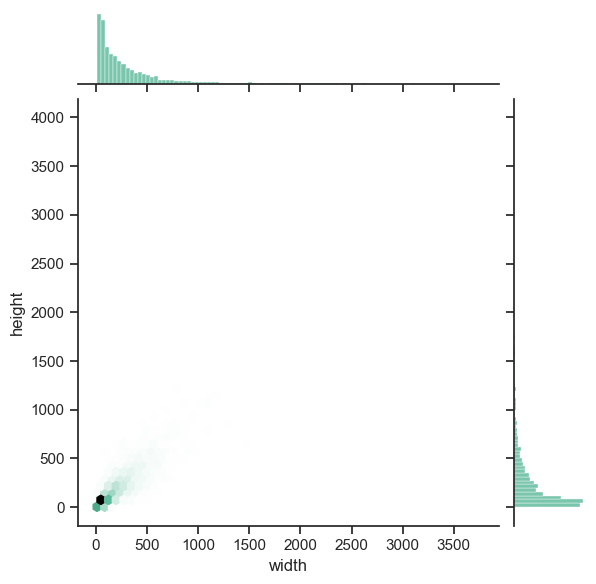

In [31]:
sns.set_theme(style="ticks")
sns.jointplot(x="width", y="height", data=taco_meta_df, kind="hex", color="#4CB391")

## Aera

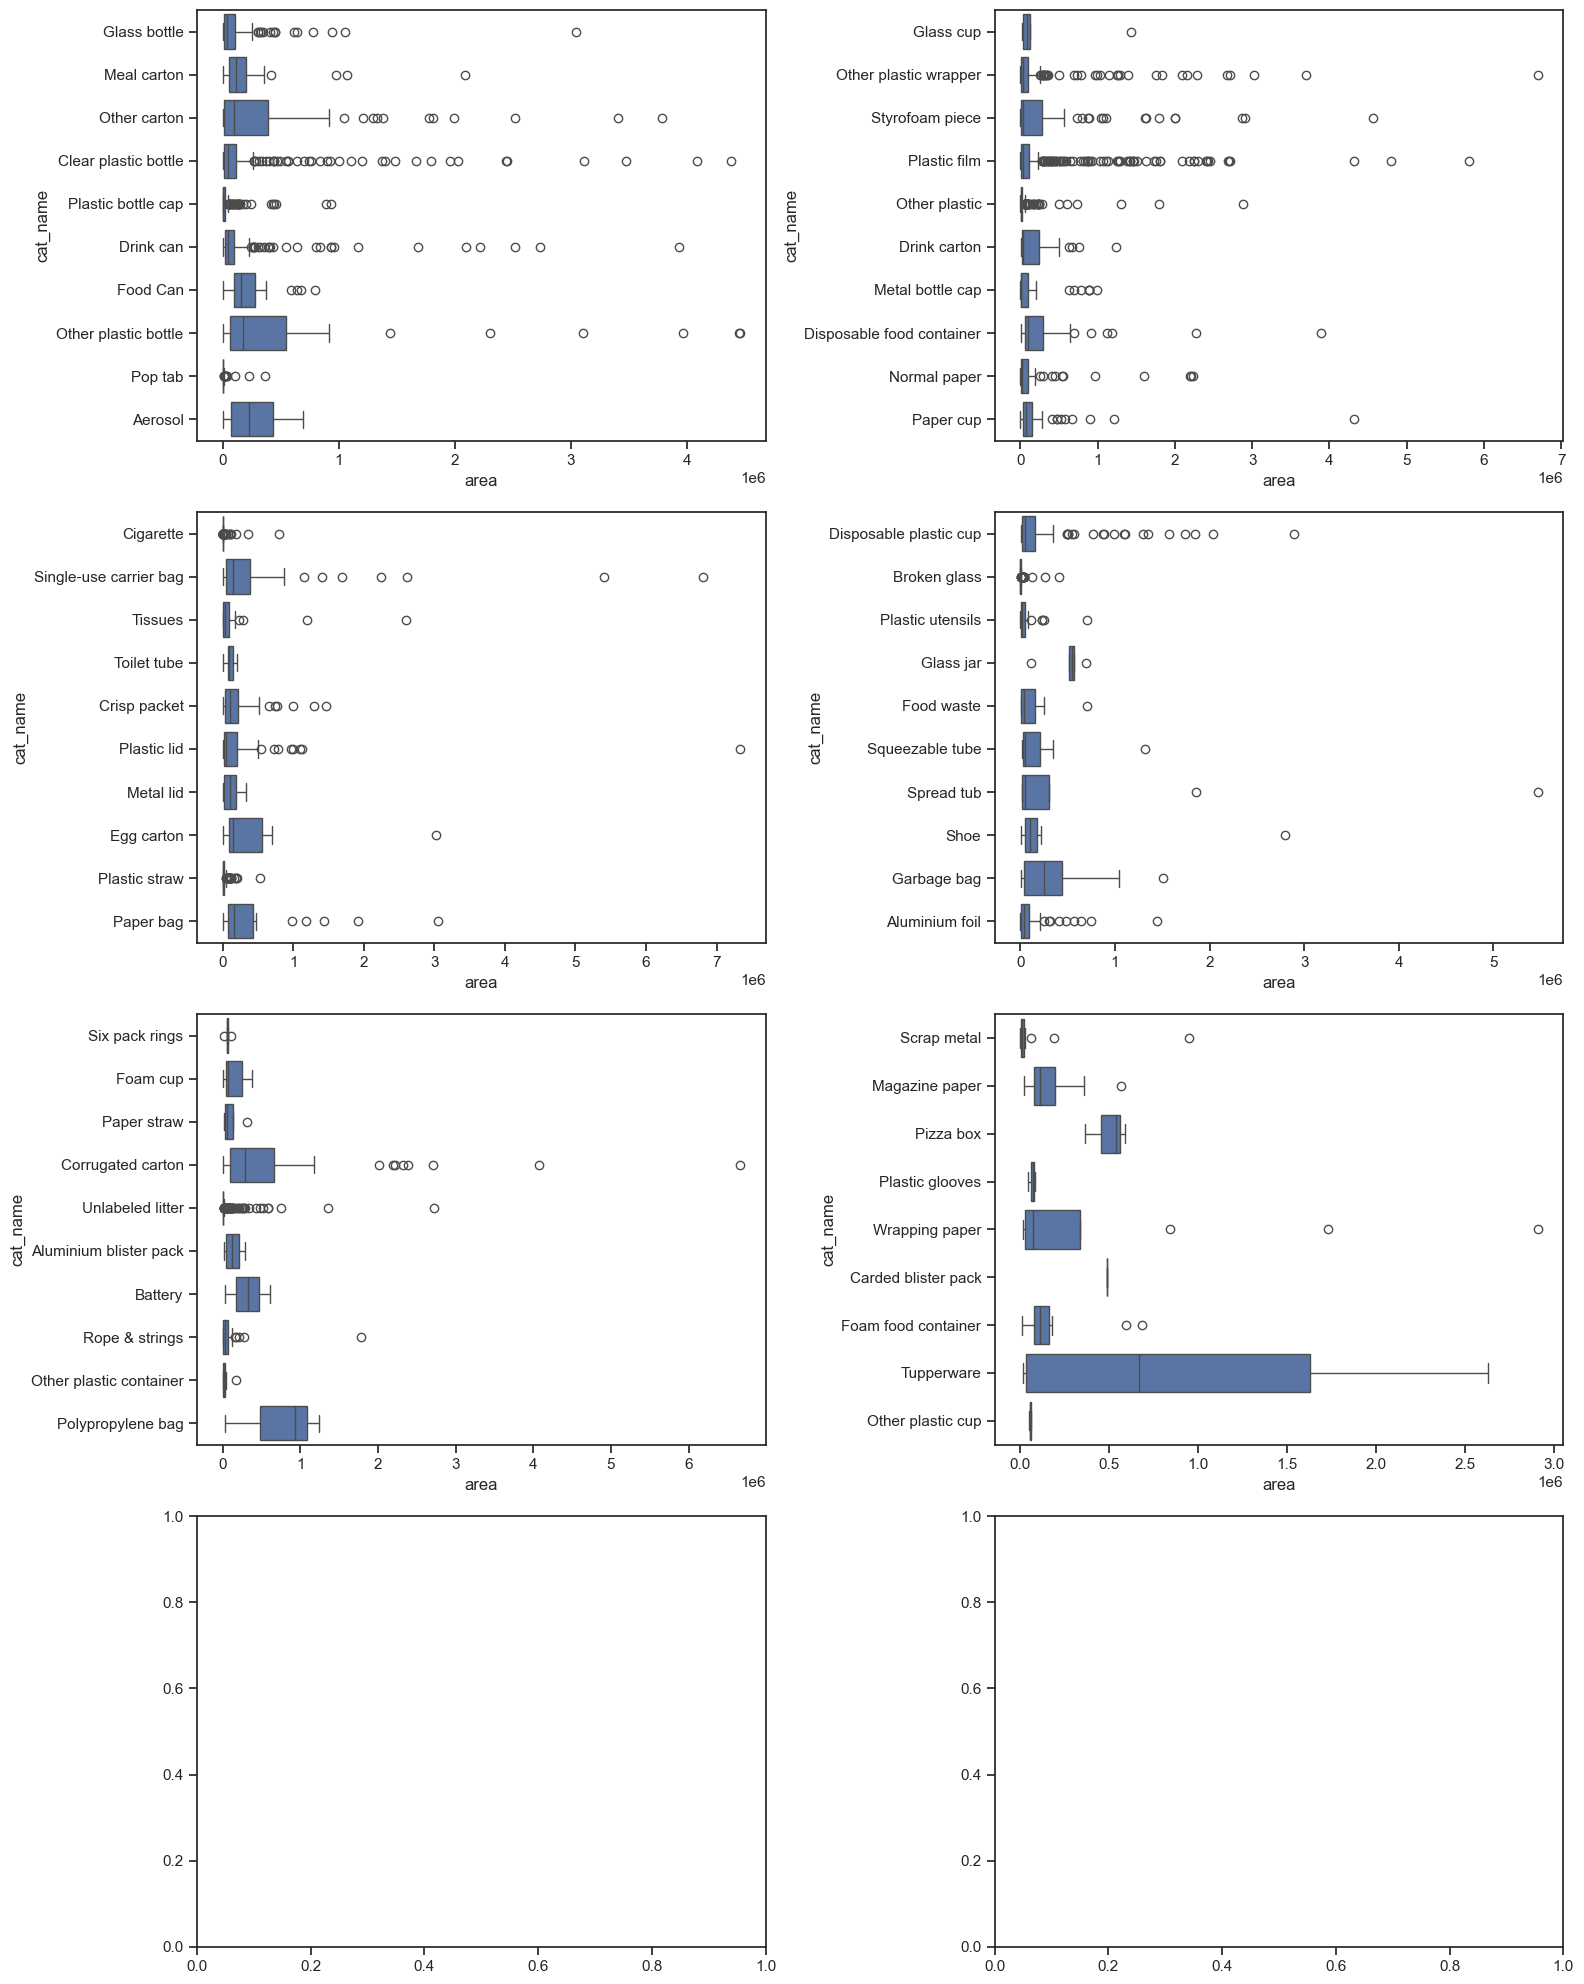

In [64]:
# list to [[], [], []] (chunk)
def chunk_list(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# chunk cat_name
cat_names_group : list = list(chunk_list(taco_meta_df['cat_name'].unique().tolist(), 10))
# area boxplot by category
# multiple plot
n_cols = 2
n_rows = len(cat_names_group) // n_cols + 1

# create figure and axes
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8*n_cols, 20))
# flatten axes
axes = axes.flatten()
# loop over cat_name
for i, cat_names in enumerate(cat_names_group):
    df = taco_meta_df[taco_meta_df['cat_name'].isin(cat_names)]
    sns.boxplot(x="area", y="cat_name", data=df, ax=axes[i])
    axes[i].set_xlabel("area")
    axes[i].set_ylabel("cat_name")
    
plt.tight_layout()
plt.show()



## Sample Images Visualization

### 'Unlabeled litter' sample images

Regardons quelques images de la catégorie 'Unlabeled litter' (Déchets non étiquetés)

<img src="reports/eda/samples-overview/taco-base-gif/cat_name/Unlabeled litter.gif" width="800" height="800" />
